# Two-link reaching

In [8]:
using InfiniteOpt, Ipopt, Plots, Distributions, ControlSystems
include("plotpvu.jl"); # plotting utility, soft abs and relu

In [9]:
twolink = InfiniteModel(Ipopt.Optimizer)
@infinite_parameter(twolink, t in [0, 1], num_supports=12, derivative_method = OrthogonalCollocation(2))
M₁ = 0.9; M₂ =1.1; L₁ = 0.25; L₂ = 0.35; S₁ = 0.11; S₂ = 0.15; I₁ = 0.065; I₂ = 0.1;
b₁₁ = 0.71; b₂₂ = 0.81; b₁₂ = 0.08; b₂₁ = 0.08; t₁=0.04; t₂=0.03;

@finite_parameter(twolink, B == 0)
@variable(twolink, τ₁, Infinite(t))
@variable(twolink, τ₂, Infinite(t))
@variable(twolink, θ₁, Infinite(t),start=t->t)
@variable(twolink, θ₂, Infinite(t),start=t->t)
@variable(twolink, θ̇₁, Infinite(t),start=t->sin(pi*t))
@variable(twolink, θ̇₂, Infinite(t),start=t->sin(pi*t))
@variable(twolink, θ̈₁, Infinite(t),start=t->pi*cos(pi*t))
@variable(twolink, θ̈₂, Infinite(t),start=t->pi*cos(pi*t))
@variable(twolink, τ̇₁, Infinite(t))
@variable(twolink, τ̇₂, Infinite(t))
@variable(twolink, τ̈₁, Infinite(t))
@variable(twolink, τ̈₂, Infinite(t))
@variable(twolink, u₁, Infinite(t))
@variable(twolink, u₂, Infinite(t))

# Kawato's equations with typos
#@constraint(twolink, τ₁==(I₁+I₂+2M₂*L₁*S₂*cos(θ₂)+M₂*L₁^2)θ̈₁ + (I₂+M₂*L₁*S₂*cos(θ₂)*θ̈₂) +
#    -M₂*L₁*S₂*(2*θ̇₁+θ̇₂)*θ̇₂ + b₁₁*θ̇₁+b₁₂*θ̇₂)
#@constraint(twolink, τ₂==(I₂+2M₂*L₁*S₂*cos(θ₂))*θ̈₁ + I₂*θ̈₂ +
#    M₂*L₁*S₂*sin(θ₂)*θ̇₁^2 + b₂₁*θ̇₁+b₂₂*θ̇₂)
    # Art's corrected version below
@constraint(twolink, τ₁==(I₁+I₂+2M₂*L₁*S₂*cos(θ₂)+M₁*S₁^2+M₂*S₂^2+M₂*L₁^2)θ̈₁ + (I₂+M₂*S₂^2+M₂*L₁*S₂*cos(θ₂)*θ̈₂) +
    -M₂*L₁*S₂*sin(θ₂)*(2*θ̇₁+θ̇₂)*θ̇₂ + b₁₁*θ̇₁+b₁₂*θ̇₂)
@constraint(twolink, τ₂==(I₂+M₂*S₂^2+M₂*L₁*S₂*cos(θ₂))*θ̈₁ + I₂*θ̈₂ +
    M₂*L₁*S₂*sin(θ₂)*θ̇₁^2 + b₂₁*θ̇₁+b₂₂*θ̇₂)


# two time constants for the muscle model of Kawato
@constraint(twolink, u₁==(t₁*t₂*τ̈₁+(t₁+t₂)*τ̇₁+τ₁))
@constraint(twolink, u₂==(t₁*t₂*τ̈₂+(t₁+t₂)*τ̇₂+τ₂))

#@objective(twolink, Min, integral(u₁.^2+u₂.^2,t))
# Minimum jerk
@objective(twolink, Min, integral(τ̇₁.^2+τ̇₂.^2,t))
@constraint(twolink, deriv(τ₁,t) == τ̇₁)  
@constraint(twolink, deriv(τ₂,t) == τ̇₂)  
@constraint(twolink, deriv(τ̇₁,t) == τ̈₁)
@constraint(twolink, deriv(τ̇₂,t) == τ̈₂)
@constraint(twolink, deriv(θ₁,t) == θ̇₁)
@constraint(twolink, deriv(θ₂,t) == θ̇₂)
@constraint(twolink, deriv(θ̇₁,t) == θ̈₁)
@constraint(twolink, deriv(θ̇₂,t) == θ̈₂)

@constraint(twolink, θ₁(0) == 0)
@constraint(twolink, θ₁(1) == 1)
@constraint(twolink, θ₂(0) == 0)
@constraint(twolink, θ₂(1) == 1)
@constraint(twolink, θ̇₁(0) == 0)
@constraint(twolink, θ̇₁(1) == 0)
@constraint(twolink, θ̇₂(0) == 0)
@constraint(twolink, θ̇₂(1) == 0)
@constraint(twolink, θ̈₁(0) == 0)
@constraint(twolink, θ̈₁(1) == 0)
@constraint(twolink, θ̈₂(0) == 0)
@constraint(twolink, θ̈₂(1) == 0)

optimize!(twolink)

#pfig = plot(layout=(1,2))
#plot!(pfig[1],supports(t), value(v))
#plot!(pfig[2], supports(t), value(F))

#pfig = plotpvu()
#for Bval in 0:0.2:2
#    set_value( B, Bval)
#    optimize!(twolink)
#    plotpvu!(pfig, twolink, t, p, v, F)
#end
#display(pfig)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      708
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      204

Total number of variables............................:      264
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      244
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

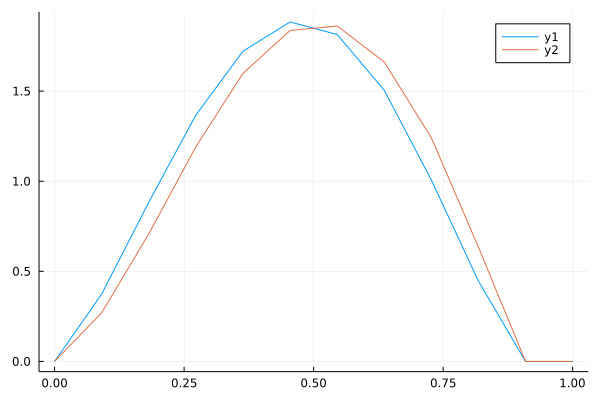

In [7]:
plot(supports(t),value(θ̇₁))
plot!(supports(t),value(θ̇₂))